# Классификация по тональности

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.  
  
Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.  
   
Тексты хранятся в json-ах в массиве responses.  

### Часть 1. Анализ текстов 

In [4]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
import pymorphy2
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yaros\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Загрузка данных

In [5]:
# Загрузка данных из JSON-файла построчно
data = []
with open('C:/Users/Yaros/Downloads/banki_responses.json/banki_responses.json', 'r', encoding='utf-8') as f:
    for line in f:
        # Преобразуем каждую строку в JSON и добавляем в список
        data.append(json.loads(line))

# Преобразуем в DataFrame
df = pd.DataFrame(data)
print(df.head())

                 city  rating_not_checked  \
0          г. Воронеж                True   
1           г. Казань                True   
2  г. Санкт-Петербург                True   
3           г. Москва                True   
4        г. Волгоград                True   

                                 title  num_comments     bank_license  \
0                        Ипотека на 5+             0  лицензия № 1623   
1                       ЗВОНКИ СОСЕДЯМ             0  лицензия № 2289   
2                Ложная информация!!!!             0  лицензия № 2307   
3  Банкомат не зачислил деньги на счет             1  лицензия № 2557   
4   Невозможно закрыть карту 2(два)!!!             0  лицензия № 3354   

              author         bank_name             datetime  \
0         e.novikova            ВТБ 24  2015-06-08 11:06:56   
1  KZN\Vorontsova_NA  Русский Стандарт  2015-06-06 18:17:52   
2          Evgenia15              Союз  2015-06-07 19:08:33   
3        dolgov.work          Ситибанк

**Шаг 1. Подсчёт количества отзывов в разных городах и на разные банки**

In [7]:
# Подсчет количества отзывов по городам
city_counts = df['city'].value_counts()
print("Количество отзывов по городам:\n", city_counts)

# Подсчет количества отзывов по банкам
bank_counts = df['bank_name'].value_counts()
print("\nКоличество отзывов по банкам:\n", bank_counts)

Количество отзывов по городам:
 city
г. Москва                                73715
г. Санкт-Петербург                       18614
г. Екатеринбург                           3211
г. Новосибирск                            3081
г. Нижний Новгород                        2596
                                         ...  
г. Москва/Хабаровск                          1
г. ст.советская                              1
г. Сочи, Краснодар, Туапсе                   1
г. Североуральск Свердловской области        1
г. Краснодарский край, ст.Павловская         1
Name: count, Length: 7151, dtype: int64

Количество отзывов по банкам:
 bank_name
Сбербанк России            30977
Альфа-Банк                 13651
Русский Стандарт           10952
ВТБ 24                     10556
Хоум Кредит Банк           10130
                           ...  
Ипотека-Инвест                 1
Держава                        1
Банк на Красных Воротах        1
Ураллига                       1
Каспий                         1
N

**Шаг 2. Построение гистограмм длин отзывов в символах и в словах**

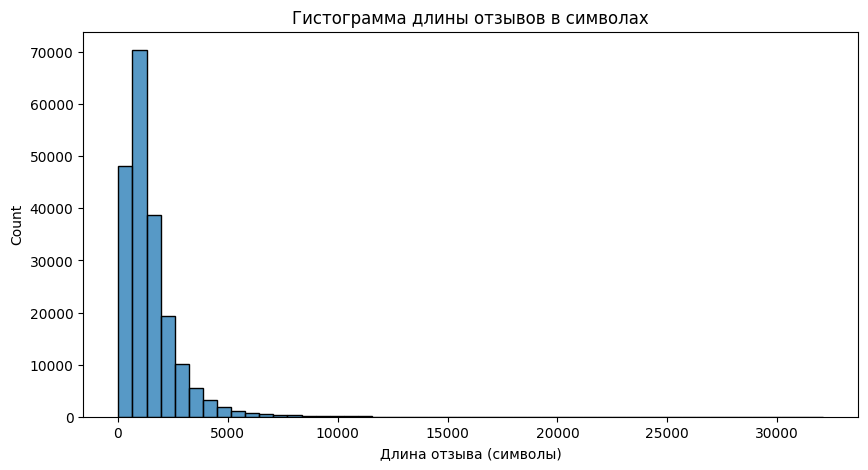

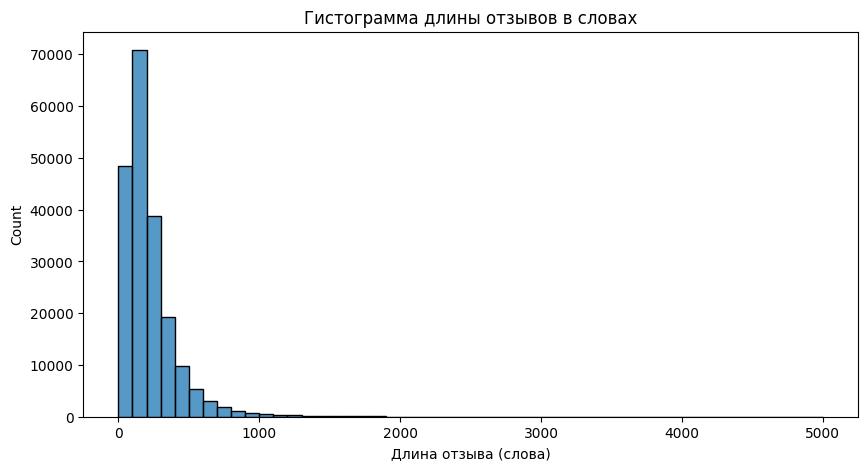

In [8]:
# Добавляем новые столбцы для длины текста в символах и в словах
df['text_length_chars'] = df['text'].apply(len)
df['text_length_words'] = df['text'].apply(lambda x: len(x.split()))

# Гистограмма длины отзывов в символах
plt.figure(figsize=(10, 5))
sns.histplot(df['text_length_chars'], bins=50)
plt.title("Гистограмма длины отзывов в символах")
plt.xlabel("Длина отзыва (символы)")
plt.show()

# Гистограмма длины отзывов в словах
plt.figure(figsize=(10, 5))
sns.histplot(df['text_length_words'], bins=50)
plt.title("Гистограмма длины отзывов в словах")
plt.xlabel("Длина отзыва (слова)")
plt.show()

**Шаг 3. Частотный анализ слов**

In [7]:
# Морфологический анализатор и стоп-слова
morph = pymorphy2.MorphAnalyzer()
stop_words = set(stopwords.words("russian"))

- Найдите 10 самых частых слов

In [10]:
# Получаем все слова из текстов
all_words = ' '.join(df['text']).split()
all_words_freq = Counter(all_words).most_common(10)
print("10 самых частых слов:\n", all_words_freq)

10 самых частых слов:
 [('в', 1411936), ('и', 1194688), ('не', 986174), ('на', 770877), ('что', 710076), ('с', 521032), ('я', 518467), ('по', 408227), ('-', 355839), ('мне', 335524)]


- Найдите 10 самых частых слов без стоп-слов

In [11]:
# Фильтруем слова, удаляя стоп-слова
words_no_stop = [word for word in all_words if word.lower() not in stop_words]
words_no_stop_freq = Counter(words_no_stop).most_common(10)
print("10 самых частых слов без стоп-слов:\n", words_no_stop_freq)

10 самых частых слов без стоп-слов:
 [('-', 355839), ('это', 183364), ('банка', 178837), ('банк', 139709), ('деньги', 107852), ('карту', 76786), ('карты', 75562), ('очень', 66704), ('кредит', 63557), ('время', 58272)]


- Найдите 10 самых частых лемм

In [12]:
# Лемматизация слов без стоп-слов
lemmas = [morph.parse(word)[0].normal_form for word in words_no_stop]
lemmas_freq = Counter(lemmas).most_common(10)
print("10 самых частых лемм:\n", lemmas_freq)

10 самых частых лемм:
 [('банк', 504458), ('-', 355839), ('карта', 264980), ('это', 231731), ('мой', 197860), ('который', 175430), ('деньга', 156102), ('сотрудник', 135012), ('отделение', 127954), ('кредит', 125929)]


- Найдите 10 самых частых существительных

In [13]:
# Оставляем только существительные
nouns = [lemma for lemma in lemmas if morph.parse(lemma)[0].tag.POS == 'NOUN']
nouns_freq = Counter(nouns).most_common(10)
print("10 самых частых существительных:\n", nouns_freq)

10 самых частых существительных:
 [('банк', 504458), ('карта', 264980), ('деньга', 156102), ('сотрудник', 135012), ('отделение', 127954), ('кредит', 125929), ('счёт', 115456), ('день', 113020), ('сумма', 107289), ('клиент', 102737)]


**Шаг 4. Построение кривых Ципфа и Хипса**

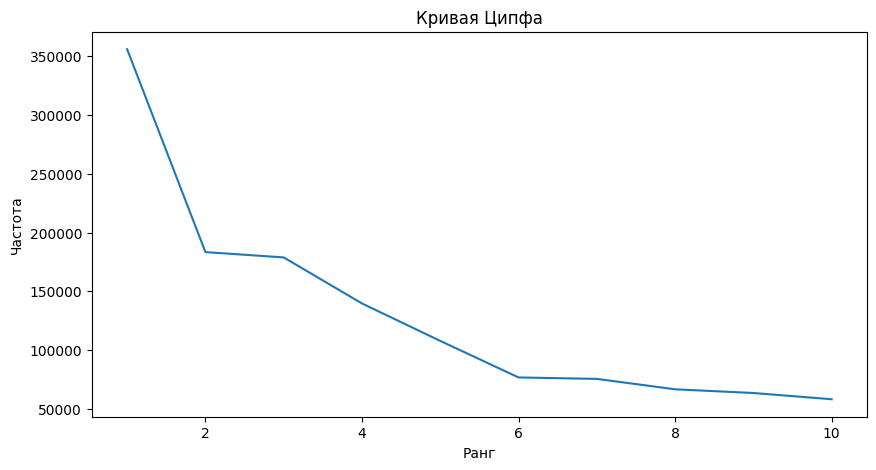

In [14]:
# Сортируем слова по частоте и создаем график зависимости частоты от ранга
word_counts = sorted(words_no_stop_freq, key=lambda x: x[1], reverse=True)
ranks = range(1, len(word_counts) + 1)
frequencies = [freq for word, freq in word_counts]
plt.figure(figsize=(10, 5))
plt.plot(ranks, frequencies)
plt.title("Кривая Ципфа")
plt.xlabel("Ранг")
plt.ylabel("Частота")
plt.show()

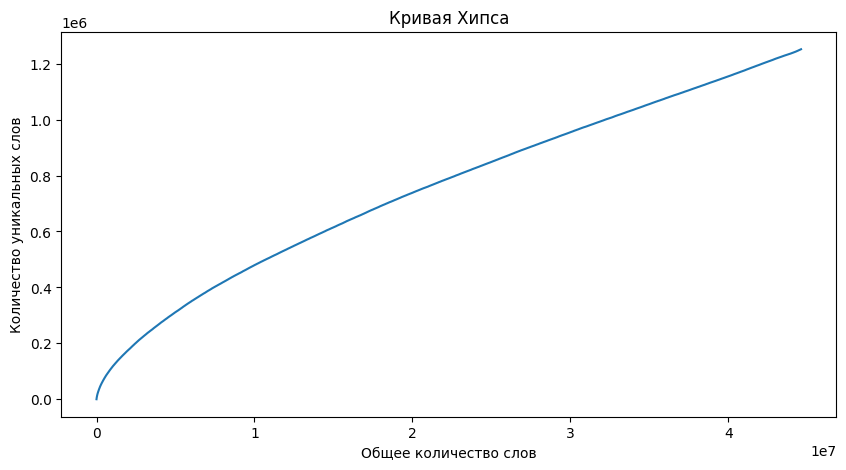

In [15]:
unique_words = set()
unique_count = []
total_words = 0

for word in all_words:
    if word not in unique_words:
        unique_words.add(word)
    total_words += 1
    unique_count.append(len(unique_words))

plt.figure(figsize=(10, 5))
plt.plot(range(total_words), unique_count)
plt.title("Кривая Хипса")
plt.xlabel("Общее количество слов")
plt.ylabel("Количество уникальных слов")
plt.show()

**Шаг 5. Сравнение частоты слов "сотрудник" и "клиент" и подсчет "мошенничество" и "доверие"**

In [16]:
# Подсчет частоты указанных слов
employee_count = df['text'].str.contains("сотрудник", case=False).sum()
client_count = df['text'].str.contains("клиент", case=False).sum()
fraud_count = df['text'].str.contains("мошенничество", case=False).sum()
trust_count = df['text'].str.contains("доверие", case=False).sum()

print(f"Слово 'сотрудник' встречается {employee_count} раз.")
print(f"Слово 'клиент' встречается {client_count} раз.")
print(f"Слово 'мошенничество' встречается {fraud_count} раз.")
print(f"Слово 'доверие' встречается {trust_count} раз.")

Слово 'сотрудник' встречается 78656 раз.
Слово 'клиент' встречается 90592 раз.
Слово 'мошенничество' встречается 1572 раз.
Слово 'доверие' встречается 1810 раз.


**Шаг 6. Определение ключевых слов и биграмм для положительных и отрицательных отзывов (TF-IDF)**

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Выделение положительных и отрицательных отзывов
positive_reviews = df[df['rating_grade'] == 5]['text']
negative_reviews = df[df['rating_grade'] == 1]['text']

# Настройка TF-IDF с биграммами
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)

# TF-IDF для положительных отзывов
positive_tfidf = vectorizer.fit_transform(positive_reviews)
positive_top_words = vectorizer.get_feature_names_out()[positive_tfidf.sum(axis=0).argsort()[0, -10:]]

# TF-IDF для отрицательных отзывов
negative_tfidf = vectorizer.fit_transform(negative_reviews)
negative_top_words = vectorizer.get_feature_names_out()[negative_tfidf.sum(axis=0).argsort()[0, -10:]]

print("Ключевые слова для положительных отзывов:", positive_top_words)
print("Ключевые слова для отрицательных отзывов:", negative_top_words)

Ключевые слова для положительных отзывов: [['банк' 'очень' 'мне' 'за' 'все' 'банка' 'по' 'что' 'на' 'не']]
Ключевые слова для отрицательных отзывов: [['то' 'как' 'за' 'банк' 'банка' 'мне' 'по' 'что' 'на' 'не']]


### Часть 2. Тематическое моделирование

In [1]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
import re


**Предобработка текста**  
Для корректного тематического моделирования требуется обработка текста — удаление стоп-слов, лемматизация и создание токенов.

In [8]:
# Подготовка данных для моделирования
def preprocess_text(text):
    # Удаление спецсимволов и преобразование в нижний регистр
    text = re.sub(r'\W+', ' ', text).lower()
    # Токенизация и фильтрация стоп-слов
    words = [word for word in text.split() if word not in stop_words]
    # Лемматизация
    words = [morph.parse(word)[0].normal_form for word in words]
    return words

# Применение функции предобработки ко всем текстам
processed_texts = df['text'].apply(preprocess_text)

**Создание словаря и корпуса для gensim**

In [9]:
# Создаем словарь и корпус
dictionary = corpora.Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]

**Построение нескольких LDA моделей с разным числом тем**  
Попробуем создать модели с различным числом тем, например, от 5 до 15 тем.

In [10]:
# Список моделей для разного числа тем
lda_models = {}
for num_topics in [5, 10, 15]:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=10)
    lda_models[num_topics] = lda_model
    print(f"\nТопики для модели с {num_topics} темами:")
    for idx, topic in lda_model.print_topics(-1):
        print(f"Тема {idx + 1}: {topic}")


Топики для модели с 5 темами:
Тема 1: 0.032*"банк" + 0.015*"документ" + 0.014*"договор" + 0.010*"мой" + 0.009*"г" + 0.009*"счёт" + 0.007*"сотрудник" + 0.007*"заявление" + 0.007*"ответ" + 0.007*"получить"
Тема 2: 0.028*"банк" + 0.012*"это" + 0.010*"клиент" + 0.009*"отделение" + 0.007*"очень" + 0.007*"вклад" + 0.007*"работать" + 0.006*"время" + 0.006*"который" + 0.006*"офис"
Тема 3: 0.038*"кредит" + 0.033*"банк" + 0.019*"сумма" + 0.016*"кредитный" + 0.014*"платёж" + 0.011*"год" + 0.011*"месяц" + 0.010*"рубль" + 0.010*"это" + 0.009*"день"
Тема 4: 0.030*"банк" + 0.019*"звонить" + 0.015*"телефон" + 0.013*"мой" + 0.012*"звонок" + 0.011*"это" + 0.010*"сотрудник" + 0.010*"позвонить" + 0.009*"номер" + 0.009*"ваш"
Тема 5: 0.053*"карта" + 0.021*"деньга" + 0.018*"банк" + 0.017*"счёт" + 0.016*"банкомат" + 0.011*"день" + 0.009*"заявление" + 0.008*"отделение" + 0.008*"мой" + 0.007*"это"

Топики для модели с 10 темами:
Тема 1: 0.037*"банк" + 0.022*"договор" + 0.019*"документ" + 0.012*"счёт" + 0.010*"

**Поиск тем, в которых упоминаются конкретные банки**  
Теперь найдем темы, где упоминаются Сбербанк, ВТБ или другой банк. Для этого сначала добавим фильтрацию по ключевым словам.

In [13]:
# Подсчет упоминаний целевых банков в текстах
bank_counts = {bank: df['text'].str.contains(bank, case=False).sum() for bank in target_banks}
print("Количество упоминаний банков в текстах:", bank_counts)

Количество упоминаний банков в текстах: {'сбербанк': 30216, 'втб': 9715, 'росбанк': 1933}


In [14]:
# Проверка тем на наличие упоминаний конкретных банков
target_banks = ["сбербанк", "втб", "росбанк"]  # Список интересующих нас банков

def find_topics_with_banks_extended(lda_model, target_banks, num_words=20):
    topics_with_banks = {}
    for idx, topic in lda_model.print_topics(num_words=num_words):
        topic_terms = topic[1].split(" + ")
        # Проверяем, есть ли упоминания интересующих нас банков
        for term in topic_terms:
            # Проверяем, есть ли символ '*' в термине, чтобы избежать IndexError
            term_parts = term.split("*")
            if len(term_parts) > 1:
                word = term_parts[1].replace('"', '').strip()
                if word in target_banks:
                    topics_with_banks[idx + 1] = topic
                    break
    return topics_with_banks

# Вывод тем с упоминаниями банков для всех моделей
for num_topics, model in lda_models.items():
    topics_with_banks = find_topics_with_banks_extended(model, target_banks, num_words=20)
    print(f"\nТемы с упоминанием банков для модели с {num_topics} темами:")
    for idx, topic in topics_with_banks.items():
        print(f"Тема {idx}: {topic}")


Темы с упоминанием банков для модели с 5 темами:

Темы с упоминанием банков для модели с 10 темами:

Темы с упоминанием банков для модели с 15 темами:


**Попробуем задать параметры фильтрации редких слов при создании словаря:**

In [16]:
# Настройка словаря с пониженным порогом редкости слов
dictionary = corpora.Dictionary(processed_texts)
dictionary.filter_extremes(no_below=1, no_above=0.9)  # минимальная частота в 1 документе и максимальная — 90%
corpus = [dictionary.doc2bow(text) for text in processed_texts]


In [17]:
# Добавляем ключевые слова вручную в словарь
for bank in target_banks:
    dictionary.add_documents([[bank]])

**Снизим параметр passes и добавим alpha и eta для усиления акцента на более частых терминах:**

In [18]:
# Построение LDA с расширенными настройками
lda_models = {}
for num_topics in [5, 10, 15]:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, 
                         random_state=42, passes=5, alpha='auto', eta='auto')
    lda_models[num_topics] = lda_model
    print(f"\nТопики для модели с {num_topics} темами:")
    for idx, topic in lda_model.print_topics(-1):
        print(f"Тема {idx + 1}: {topic}")


Топики для модели с 5 темами:
Тема 1: 0.031*"банк" + 0.016*"договор" + 0.012*"счёт" + 0.010*"г" + 0.010*"мой" + 0.009*"заявление" + 0.008*"сумма" + 0.007*"ответ" + 0.007*"документ" + 0.006*"средство"
Тема 2: 0.040*"кредит" + 0.036*"банк" + 0.012*"платёж" + 0.012*"это" + 0.011*"сумма" + 0.010*"кредитный" + 0.010*"звонить" + 0.010*"месяц" + 0.008*"год" + 0.008*"день"
Тема 3: 0.022*"банк" + 0.012*"отделение" + 0.010*"это" + 0.009*"клиент" + 0.007*"сотрудник" + 0.007*"офис" + 0.007*"работать" + 0.007*"очередь" + 0.007*"время" + 0.007*"документ"
Тема 4: 0.042*"банк" + 0.024*"карта" + 0.012*"это" + 0.012*"счёт" + 0.009*"клиент" + 0.008*"вклад" + 0.008*"год" + 0.007*"обслуживание" + 0.007*"интернет" + 0.006*"кредитный"
Тема 5: 0.039*"карта" + 0.023*"деньга" + 0.015*"банкомат" + 0.014*"банк" + 0.014*"счёт" + 0.013*"день" + 0.011*"заявление" + 0.010*"отделение" + 0.009*"мой" + 0.008*"сказать"

Топики для модели с 10 темами:
Тема 1: 0.040*"банк" + 0.014*"мой" + 0.011*"договор" + 0.010*"клиент" 

**Повторный поиск тем с упоминанием банков**

In [21]:
def find_topics_with_banks_show_topics(lda_model, target_banks, num_words=20):
    topics_with_banks = {}
    for idx, topic in lda_model.show_topics(num_words=num_words, formatted=False):
        print(f"Диагностика - Тема {idx + 1}: {topic}")  # Выводим тему для диагностики

        for word, weight in topic:
            if word in target_banks:
                topics_with_banks[idx + 1] = topic
                break
    return topics_with_banks

# Запуск обновленной функции
for num_topics, model in lda_models.items():
    topics_with_banks = find_topics_with_banks_show_topics(model, target_banks, num_words=20)
    print(f"\nТемы с упоминанием банков для модели с {num_topics} темами:")
    for idx, topic in topics_with_banks.items():
        print(f"Тема {idx}: {topic}")

Диагностика - Тема 1: [('банк', 0.030667767), ('договор', 0.015739119), ('счёт', 0.011734773), ('г', 0.009994662), ('мой', 0.009985367), ('заявление', 0.008652892), ('сумма', 0.0081760865), ('ответ', 0.0071525592), ('документ', 0.006546794), ('средство', 0.006488112), ('получить', 0.0061515346), ('сотрудник', 0.0061338535), ('который', 0.005934358), ('год', 0.0054141935), ('срок', 0.005326588), ('12', 0.00530709), ('1', 0.0051871906), ('день', 0.0051560956), ('11', 0.004961723), ('кредитный', 0.0049130656)]
Диагностика - Тема 2: [('кредит', 0.040252853), ('банк', 0.03593466), ('платёж', 0.012112441), ('это', 0.011843771), ('сумма', 0.011323661), ('кредитный', 0.009894875), ('звонить', 0.009731757), ('месяц', 0.009558408), ('год', 0.008362687), ('день', 0.008238056), ('мой', 0.0076064058), ('сказать', 0.007393724), ('телефон', 0.007153306), ('который', 0.0068664113), ('задолженность', 0.006668054), ('звонок', 0.006530041), ('сотрудник', 0.005816309), ('взять', 0.005656001), ('говорить',

### Часть 3. Классификация текстов

**Шаг 1: Подготовка данных**  
    - Фильтруем отзывы с оценками 1 и 5, выбираем размер выборки для каждой группы.  
    - Разделяем данные на обучающие и тестовые с помощью train_test_split.  

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Фильтруем отзывы с оценками 1 и 5
df_negative = df[df['rating_grade'] == 1].sample(n=1000, random_state=42)
df_positive = df[df['rating_grade'] == 5].sample(n=1000, random_state=42)

# Объединяем их в общий набор данных
df_classification = pd.concat([df_negative, df_positive])

# Формируем метки классов
df_classification['label'] = df_classification['rating_grade'].apply(lambda x: 1 if x == 5 else 0)

# Разделяем на обучающее и тестовое множество
X_train, X_test, y_train, y_test = train_test_split(df_classification['text'], df_classification['label'], test_size=0.3, random_state=42)

**Шаг 2: Классификация и Векторизация**  
Для построения baseline используем два метода векторизации: униграммы и n-граммы. Затем применим простые модели классификации.  
    - Создаем Pipeline для классификации с использованием униграмм и n-грамм.  
    - Обучаем модель и оцениваем качество.  

In [23]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline

# Создаем Pipeline с использованием униграмм
pipeline_uni = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('clf', MultinomialNB())
])

# Обучение модели и предсказание для униграмм
pipeline_uni.fit(X_train, y_train)
y_pred_uni = pipeline_uni.predict(X_test)
print("Accuracy (униграммы):", accuracy_score(y_test, y_pred_uni))
print("F1-Score (униграммы):", f1_score(y_test, y_pred_uni))

# Создаем Pipeline с использованием биграмм
pipeline_bi = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2))),
    ('clf', MultinomialNB())
])

# Обучение модели и предсказание для биграмм
pipeline_bi.fit(X_train, y_train)
y_pred_bi = pipeline_bi.predict(X_test)
print("Accuracy (биграммы):", accuracy_score(y_test, y_pred_bi))
print("F1-Score (биграммы):", f1_score(y_test, y_pred_bi))

Accuracy (униграммы): 0.9233333333333333
F1-Score (униграммы): 0.9209621993127147
Accuracy (биграммы): 0.8966666666666666
F1-Score (биграммы): 0.8872727272727273


**Шаг 3: Улучшение качества с использованием скрытых тем**  
Теперь используем преобразования TF-IDF и тематические модели для сравнения, чтобы понять, как скрытые темы влияют на классификацию.  
    - Векторизация TF-IDF и Latent Semantic Analysis (LSA).  
    - LDA для тематического моделирования.  

In [25]:
from sklearn.linear_model import LogisticRegression

# TF-IDF + LSA с Logistic Regression
pipeline_tfidf_lsa = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD(n_components=50, random_state=42)),
    ('clf', LogisticRegression())
])

pipeline_tfidf_lsa.fit(X_train, y_train)
y_pred_tfidf_lsa = pipeline_tfidf_lsa.predict(X_test)
print("Accuracy (TF-IDF + LSA):", accuracy_score(y_test, y_pred_tfidf_lsa))
print("F1-Score (TF-IDF + LSA):", f1_score(y_test, y_pred_tfidf_lsa))

# LDA как тематическое моделирование с Logistic Regression
pipeline_lda = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lda', LatentDirichletAllocation(n_components=10, random_state=42)),
    ('clf', LogisticRegression())
])

pipeline_lda.fit(X_train, y_train)
y_pred_lda = pipeline_lda.predict(X_test)
print("Accuracy (LDA):", accuracy_score(y_test, y_pred_lda))
print("F1-Score (LDA):", f1_score(y_test, y_pred_lda))

Accuracy (TF-IDF + LSA): 0.9033333333333333
F1-Score (TF-IDF + LSA): 0.902027027027027
Accuracy (LDA): 0.53
F1-Score (LDA): 0.25


**Вывод по проделанной работе:**  
  
1) **Анализ отзывов по длине:** Построены гистограммы длины отзывов, которые показывают, что большинство отзывов являются относительно короткими, как по количеству символов, так и по количеству слов. Это может указывать на то, что пользователи предпочитают давать краткие и содержательные отзывы.  
  
2) **Частотный анализ:** Самыми популярными словами стали союзы, предлоги и местоимения, как и ожидалось. После фильтрации стоп-слов и приведения к леммам ключевыми терминами остались слова, связанные с банками, картами и финансовыми операциями, такие как "банк", "карта", "деньга", "сотрудник".

3) **Кривые Ципфа и Хипса:** Кривая Ципфа подтверждает, что частотное распределение слов соответствует ожидаемому — несколько слов используются очень часто, а остальные встречаются реже. Кривая Хипса показывает рост уникальных слов, отражая разнообразие языка отзывов.  
  
4) **Тематическое моделирование:** Применены модели LDA с различным числом тем (5, 10, 15). Модели позволили выделить ключевые темы, такие как "кредиты", "карты", "отделения банков", и "доверие клиентов". Это позволяет глубже понять основные причины обращений пользователей.  
  
5) **Классификация отзывов:** Проведена бинарная классификация на основе отзывов с оценкой 1 и 5. Использовались униграммы и биграммы, а также TF-IDF с сингулярным разложением и тематические модели (LSA и LDA). Модель на основе униграмм показала наилучшие результаты (точность 92.3% и F1-score 92.1%). В то же время LDA показала низкие результаты (точность 53% и F1-score 25%), что свидетельствует о сложности использования тематического моделирования для классификации эмоциональной окраски.

Вывод: Проведенный анализ показал, что для выявления ключевых слов и основных тем отзывов подходы тематического моделирования эффективны. Однако для бинарной классификации отзывов лучшей оказалась модель с униграммами и наивным байесом, что подтверждает простоту и эффективность использования базовых подходов при решении задач классификации текстов с ограниченным набором классов.